In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import *
from uta import Uta
from norm_layer import NormLayer
from threshold_layer import ThresholdLayer


# Model

In [33]:
class Promethee(nn.Module):
    """PROMETHEE method
    """    
    def __init__(self, num_criteria:int, hidden_nr:int, slope:float=0.01):
        """Constructor for PROMETHEE method

        Args:
            num_criteria (int): Number of criteria
            hidden_nr (int): Number of hidden components of monotonic block.
            slope (float, optional): Slope value for LeakyHardSigmoid. Defaults to 0.01.
        """

        super().__init__()
        self.uta = Uta(num_criteria, hidden_nr, slope)
        self.num_criteria = num_criteria
        self.threshold_layer = ThresholdLayer()

    def set_slope(self,val:float):
        """
        Set the slope value for the LeakyHardSigmoid activation function.

        Args:
            val (float): Slope value.
        """
        self.uta.set_slope(val)

    def forward(self,input:torch.Tensor) -> torch.Tensor:
        """Forward pass of the PROMETHEE method.

        Args:
            input (torch.Tensor): Input tensor of shape (batch_size, num_criteria)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1)
        """
        out = []
        for i in range(len(input)):
            out.append(self.uta(F.relu(input[i]-input)).view(-1,1))
        out = torch.cat(out,1)
        zero_input = torch.FloatTensor(self.num_criteria).zero_().view(1,1,-1).to(out.device)
        self.zero = self.uta(zero_input)
        self.one = self.uta(zero_input+1)

        out = (out-self.zero)/(self.one-self.zero)

        positive_flow = out.sum(0)/(len(input)-1)
        negative_flow = out.sum(1)/(len(input)-1)
        total_flow = positive_flow - negative_flow
        return self.threshold_layer(total_flow).reshape(-1,1)

# Load data

In [50]:
path = 'data/lectures evaluation.csv'
data = pd.read_csv(path,header=None)
target_map = {0:0,1:0,2:0,3:1,4:1}
num_criteria = 4
data_input = data.iloc[:,:num_criteria]
data_target = data[num_criteria].apply(lambda x: target_map[x])

data_input = data_input.values.reshape(-1,1,num_criteria)

X_train, X_test, y_train, y_test = train_test_split(data_input,
                                                    data_target.values,
                                                    test_size=0.2,
                                                    random_state=1234)

In [51]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)


In [52]:
PATH = 'promethee.pt2'

# Model creation and training

In [66]:
model = Promethee(num_criteria, 20)
(
    best_acc,
    best_auc,
    stats_train,
    stats_test,
)  = Train(model, train_dataloader, test_dataloader, PATH, epoch_nr=50,lr=0.001)

100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


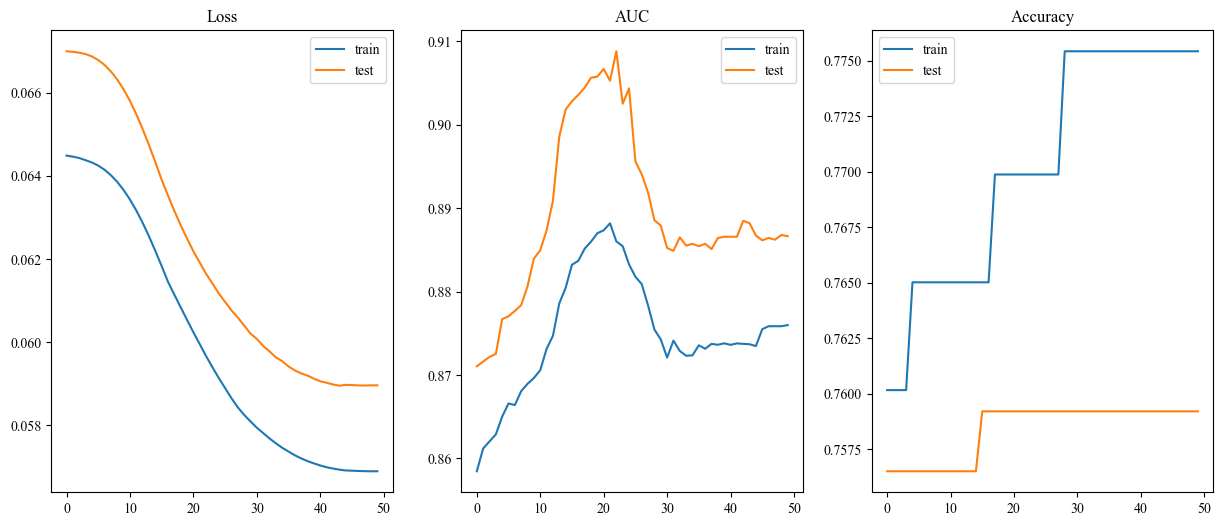

In [67]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()

# Ploting marginal value functions of best model

In [55]:

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [59]:
def get_simple_input(val: float, num_criteria: int) -> torch.Tensor:
    """
    Creates a simple input tensor with the provided value for first alternative 
    and zeros for the second.

    Args:
        val (float): The value to fill the first alternative with.
        num_criteria (int): The total number of criteria  in the tensor.

    Returns:
        torch.Tensor: The created input tensor with shape (2, 1, num_criteria).
    """
    first_alternative = torch.full((1, 1, num_criteria), val, dtype=torch.float)
    second_alternative = torch.zeros((1, 1, num_criteria), dtype=torch.float)
    input_tensor = torch.cat((first_alternative, second_alternative), dim=0)
    return input_tensor.cpu()
    #return torch.FloatTensor([[val]*num_criteria]+ [[0.]*num_criteria]).view(2,1,-1).cpu()


hook = Hook(model.uta.monotonic_layer.criterion_layer_combine, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = (i-100)/100.
        input = get_simple_input(val,num_criteria)
        xs.append(val)
        model(input)

outs = np.array(torch.stack(hook.stats[::4])[:,1].detach().cpu())


outs = outs/outs[-1].sum()

In [61]:
outs.shape

(201, 4)

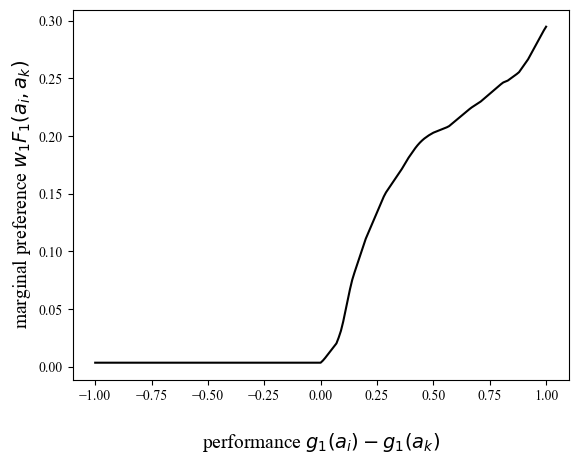

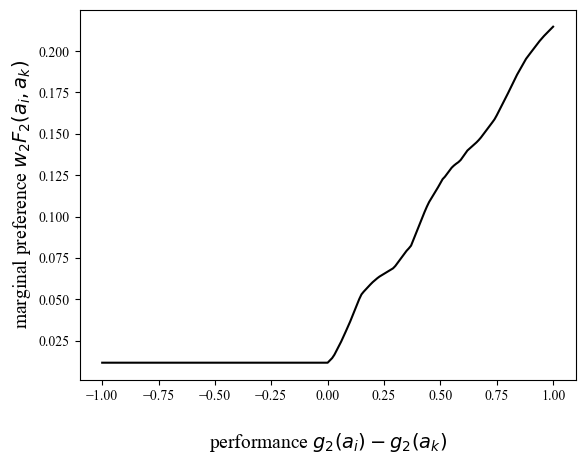

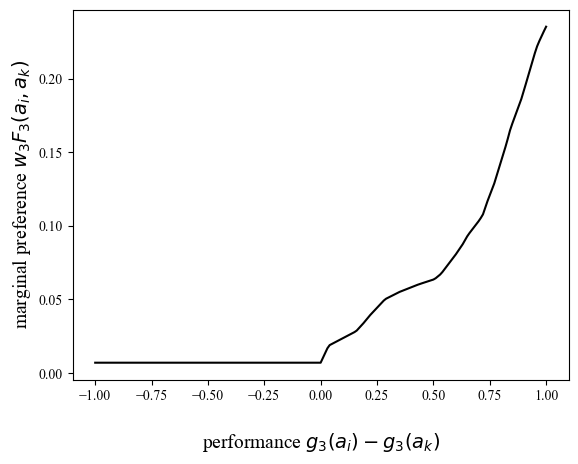

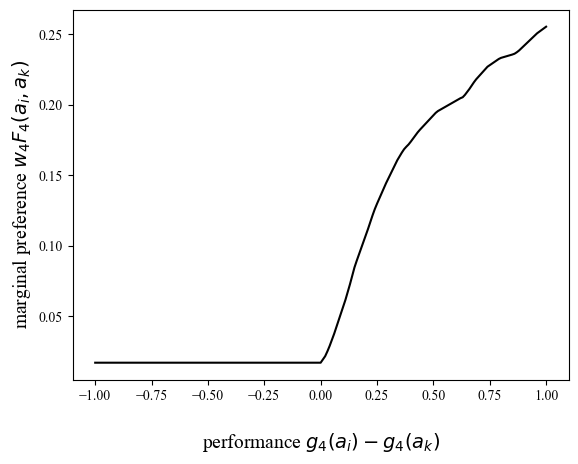

In [62]:
for i in range(outs.shape[1]):
    plt.plot(xs,outs[:,i],color='black')
    plt.ylabel("marginal preference $w_{0} F_{0}(a_i,a_k)$".format(i+1),fontsize=14)
    plt.xlabel("performance $g_{0}(a_i) - g_{0}(a_k)$".format(i+1),fontsize=14,labelpad=20)

    plt.show()